In [9]:
!pip install langchain langchain_community

In [10]:
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun  
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [11]:
!pip install arxiv

In [12]:
api_wrapper_arxiv=ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=600) 
arxiv=ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers") 
print(arxiv.name)

arxiv


In [14]:
arxiv.invoke("attention is all you need")


"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally"

In [33]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=600)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki, description="Query Wikipedia for general knowledge")
print(wiki.invoke("India"))

Page: India
Summary: India, officially the Republic of India, is a country in South Asia.  It is the seventh-largest country by area; the most populous country from June 2023 onwards; and since its independence in 1947, the world's most populous democracy. Bounded by the Indian Ocean on the south, the Arabian Sea on the southwest, and the Bay of Bengal on the southeast, it shares land borders with Pakistan to the west; China, Nepal, and Bhutan to the north; and Bangladesh and Myanmar to the east. In the Indian Ocean, India is near Sri Lanka and the Maldives; its Andaman and Nicobar Islands sha


In [16]:
from dotenv import load_dotenv 
import os

load_dotenv() 

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


In [17]:
from langchain_community.tools.tavily_search import TavilySearchResults 
tavily=TavilySearchResults()

In [18]:
tavily.invoke("provide me recent ai news")

[{'url': 'https://www.artificialintelligence-news.com/',
  'content': 'AI News reports on the latest artificial intelligence news and insights. Explore industry trends from the frontline of AI.'},
 {'url': 'https://www.wsj.com/tech/ai',
  'content': 'The latest artificial intelligence news coverage focusing on the technology, tools and the companies building AI technology.'},
 {'url': 'https://www.nbcnews.com/artificial-intelligence',
  'content': "NBC News NOW\n\n02:54\n\nA.I. chatbots becoming popular but worry privacy advocates\n\nNightly News\n\n03:15\n\nChristie's begins AI art auction amid backlash\n\nNBC News NOW\n\n02:16\n\nVance says U.S. will be the ‘gold standard’ of AI technology\n\n03:36\n\nAI startup DeepSeek causes buzz in China but draws global scrutiny over censorship and security\n\nNBC News NOW\n\nMORE AI NEWS\n\nMusk's xAI says Grok's 'white genocide' posts came after unauthorized change to the bot [...] Profile\n\nSections\n\nLocal\n\ntv\n\nFeatured\n\nMore From NB

In [19]:
from langchain_groq import ChatGroq 
llm=ChatGroq(model="qwen-qwq-32b") 


In [35]:
from langchain_core.tools import tool

@tool
def arxiv_tool(query: str) -> str:
    """Search academic papers from Arxiv."""
    return arxiv.run(query)

@tool
def wikipedia_tool(query: str) -> str:
    """Search Wikipedia for general knowledge."""
    return wiki.run(query)

@tool
def tavily_tool(query: str) -> str:
    """Search Tavily for web search results."""
    return tavily.run(query)

tools = [arxiv_tool, wikipedia_tool, tavily_tool]
llm_with_tools = llm.bind_tools(tools=tools)

In [36]:
llm_with_tools.invoke("what is latest research on ai?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pwhq', 'function': {'arguments': '{"query":"latest artificial intelligence research"}', 'name': 'arxiv_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 264, 'prompt_tokens': 272, 'total_tokens': 536, 'completion_time': 0.599532361, 'prompt_time': 0.020289425, 'queue_time': 0.37352030999999997, 'total_time': 0.619821786}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_28178d7ff6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-af207d92-2113-4406-bd28-64359a409560-0', tool_calls=[{'name': 'arxiv_tool', 'args': {'query': 'latest artificial intelligence research'}, 'id': 'call_pwhq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 272, 'output_tokens': 264, 'total_tokens': 536})

WORKFLOW


In [37]:
from typing_extensions import TypedDict 
from langchain_core.messages import AnyMessage 
from typing import Annotated 
from langgraph.graph.message import add_messages

In [38]:
class State(TypedDict): 
    messages: Annotated[list[AnyMessage],add_messages]

In [43]:
from IPython.display import Image , display 
from langgraph.graph import StateGraph,START,END 
from langgraph.prebuilt import ToolNode 
from langgraph.prebuilt import tools_condition 
from langchain_core.messages import HumanMessage

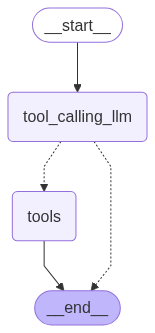

In [42]:
def tool_calling_llm(state: State): 
    return {"messages": [llm_with_tools.invoke(state["messages"])]}  

# Build graph 
builder = StateGraph(State) 
builder.add_node("tool_calling_llm", tool_calling_llm) 
builder.add_node("tools", ToolNode(tools))  

# Edges 
builder.add_edge(START, "tool_calling_llm") 
builder.add_conditional_edges( 
    "tool_calling_llm",
    tools_condition,
    {"tools": "tools", END: END}
)
builder.add_edge("tools", END)

# Compile the graph
graph = builder.compile() 
display(graph)

In [48]:
messages=graph.invoke({"messages":HumanMessage(content="provide me latest news on operation sindoor")}) 
for m in messages["messages"]: 
    m.pretty_print()

================================ Human Message =================================

provide me latest news on operation sindoor
================================== Ai Message ==================================
Tool Calls:
  tavily_tool (call_8fnw)
 Call ID: call_8fnw
  Args:
    query: latest news on Operation Sindoor
================================= Tool Message =================================
Name: tavily_tool

[{"url": "https://www.rusi.org/explore-our-research/publications/commentary/calibrated-force-operation-sindoor-and-future-indian-deterrence", "content": "Calibrated Force: Operation Sindoor and the Future of Indian Deterrence\n\nCautious response: An Indian policeman and others look at part of an unknown, crashed aircraft in Wuyan near Indian-administered Kashmir's main city of Srinagar, Jammu And Kashmir, India 8 May, 2025.  Image: ZUMA Press Inc / Alamy Stock Photo\n\nThe strikes by the Indian Air Force against targets in Pakistan offer a powerful lesson in restraint, and Op